In [3]:
import torch
import torch.nn as nn
import numpy as np
import scipy as sp 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import init
import pytorch_lightning as pL
import torch.optim as optim

In [4]:
def psnr_to_timestep(psnr, minpsnr, maxpsnr, num_timesteps):
    """
    psnr - the psnr value to convert to a timestep
    minpsnr - the minimum psnr value that can be achieved
    maxpsnr - the maximum psnr value that can be achieved
    num_timesteps - the number of timesteps in the simulation
    This function takes a psnr as import, performs min-max normalisation and then converts it into a timestep
    """
    psnr = torch.FloatTensor([psnr])
    minpsnr = torch.FloatTensor([minpsnr])
    maxpsnr = torch.FloatTensor([maxpsnr])
    
    psnr = torch.maximum(torch.minimum(psnr, maxpsnr), minpsnr)
    normalised_psnr = ((psnr - minpsnr) / (maxpsnr - minpsnr))
    timestep = (num_timesteps-1)*normalised_psnr
    return torch.Tensor([timestep]).to(torch.long)
psnr_to_timestep(-39.0, -40.0, -5, 1024)

tensor([29])

In [5]:
def Positional_Embedder(num_timesteps, d_model):
    """
    num_timesteps - the timestep to embed
    d_model - the dimension of the model
    This function takes a timestep as input and returns a positional embedding of the timestep
    """
    position = torch.arange(0, num_timesteps).unsqueeze(1)
    division_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
    pos_embedding = torch.zeros((num_timesteps, d_model))
    pos_embedding[:, 0::2] = torch.sin(position * division_term)
    pos_embedding[:, 1::2] = torch.cos(position * division_term)
    return pos_embedding
    

Positional_Embedding = Positional_Embedder(1000, 512)
Positional_Embedding.shape

torch.Size([1000, 512])

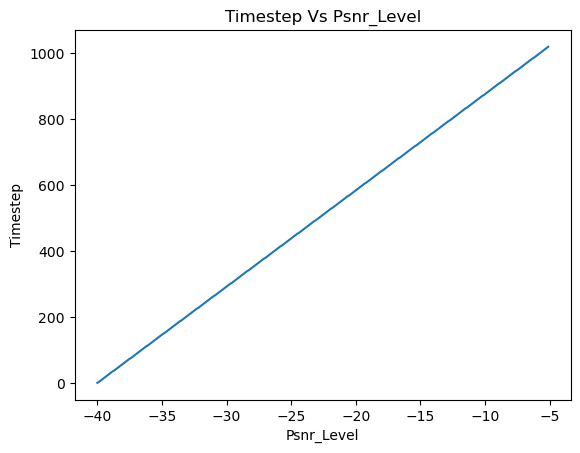

In [6]:
psnr_scores = np.arange(-40, -5, 0.1)
timesteps = np.array([psnr_to_timestep(psnr, -40, -5, 1024) for psnr in psnr_scores])
plt.plot(psnr_scores, timesteps)
plt.xlabel("Psnr_Level")
plt.ylabel("Timestep")
plt.title("Timestep Vs Psnr_Level")
plt.show()

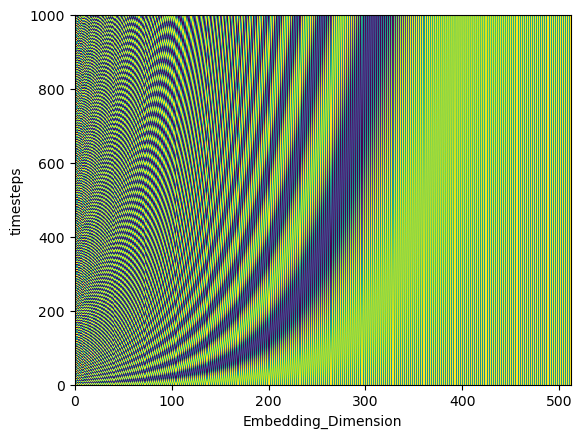

In [7]:
plt.pcolormesh(Positional_Embedding.cpu().numpy(), cmap='viridis')
plt.xlabel("Embedding_Dimension")
plt.ylabel("timesteps")
plt.show()

In [8]:
Positional_Embedding[psnr_to_timestep(-32.0, -40.0, -5, 1000)].shape

torch.Size([1, 512])

In [9]:
# Define the Down-sampling layers of the convolutional network
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

def Swish():
    return nn.SiLU()

def GeLU():
    return nn.GELU()

In [10]:
class Temporal_Embedder(nn.Module):
    def __init__(self, n_channels):
        super(Temporal_Embedder, self).__init__()
        self.n_channels = n_channels
        self.Linear_1 = nn.Linear(self.n_channels//4, self.n_channels)
        self.Linear_2 = nn.Linear(self.n_channels, self.n_channels)
        self.Swish_1 = Swish()
        self.Swish_2 = Swish()

    def forward(self, t):
        half_dim = self.n_channels//8
        constant = torch.FloatTensor([10000.0], device = t.device)
        emb = torch.log(constant, device = t.device) / (half_dim -1)
        emb = torch.exp(torch.arange(half_dim, device = t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim = 1)
        
        emb = self.Swish_1(self.Linear_1(t))
        emb = self.Swish_2(self.Linear_2(t))
        return emb

In [11]:
class SEblock(nn.Module):
    def __init__(self, units, bottlenecks, dropout_rate):
        super(SEblock, self).__init__()
        
        self.units = units
        self.bottlenecks = bottlenecks
        self.dropout_rate = dropout_rate
        
        # Define the SE Block layers
        self.Dense = nn.LazyLinear(units)
        self.Dropout = nn.Dropout2d(dropout_rate)
        self.GlobalPool = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        x = self.GlobalPool(x)
        x = x.view(x.size(0), -1)
        x = self.Dense(x)
        x = F.leaky_relu(x)
        x = self.Dense_2(x)
        x = F.sigmoid(x)
        x = x.view(-1, self.units, 1, 1)
        return x

In [12]:
class Residual_Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels,
                dropout_rate, n_groups = 8, stride=1):
        
        super(Residual_Block, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate
        self.stride = stride
        self.n_groups = n_groups
        self.time_channels = time_channels

        # Define the residual block layers

        self.time_embedding = nn.Linear(time_channels, out_channels)
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv1x1(in_channels, out_channels)

        self.GroupNorm_1 = nn.GroupNorm(n_groups, in_channels)
        self.GroupNorm_2 = nn.GroupNorm(n_groups, out_channels)
        self.Batch_Norm_1 = nn.BatchNorm2d(in_channels)

        self.dropout_1 = nn.Dropout(dropout_rate)
        self.dropout_2 = nn.Dropout(dropout_rate)

        self.Swish_1 = Swish()
        self.Swish_2 = Swish()
        self.Swish_3 = Swish()
        self.Swish_4 = Swish()

    def forward(self, x, t):
        x_skip = self.Batch_Norm_1(self.conv3(x))
        
        x = self.conv1(self.Swish_1(self.GroupNorm_1(x)))
        x = self.dropout_1(x)

        h = self.Swish_4(self.time_embedding(t)[:,:,None,None])
        x += h

        x = self.conv2(self.Swish_2(self.GroupNorm_2(x)))
        x = self.dropout_2(x)
        x += x_skip
    
        return x


class Efficient_Residual_Block(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, time_channels, 
                 out_channels, dropout_rate, n_groups = 8, stride=1):
        
        super(Efficient_Residual_Block, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate
        self.stride = stride
        self.n_groups =  n_groups
        self.time_channels = time_channels

        # Define the residual block layers

        self.time_embedding = nn.Linear(time_channels, bottleneck_channels)
        self.conv1 = conv1x1(in_channels, bottleneck_channels)
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.conv3 = conv1x1(bottleneck_channels, out_channels)

        self.GroupNorm_1 = nn.GroupNorm(self.n_groups, in_channels)
        self.GroupNorm_2 = nn.GroupNorm(self.n_groups, bottleneck_channels)
        self.GroupNorm_2 = nn.GroupNorm(self.n_groups, out_channels)
        self.Batch_Norm_1 = nn.BatchNorm2d(in_channels)

        self.dropout_1 = nn.Dropout2d(dropout_rate)
        self.dropout_2 = nn.Dropout2d(dropout_rate)
        self.dropout_3 = nn.Dropout2d(dropout_rate)

        self.Swish_1 = Swish()
        self.Swish_2 = Swish()
        self.Swish_3 = Swish()
        self.Swish_4 = Swish()

    def forward(self, x, t):
        x_skip = self.Batch_Norm_1(self.conv3(x))
        
        x = self.conv1(self.Swish_1(self.GroupNorm_1(x)))
        x = self.dropout_1(x)

        x = self.conv2(self.Swish_2(self.GroupNorm_2(x)))
        x = self.dropout_2(x)

        h = self.Swish_4(self.time_embedding(t)[:,:, None, None])
        x += h

        x = self.conv3(self.Swish_3(self.GroupNorm_3(x)))
        x = self.dropout_3(x)

        x += x_skip

        return x
    
class SqueezeExtraction_Block(nn.Module):
    def __init__(self, filters, units, dropout_rate,
                 time_channels, units_bottleneck, n_groups = 8):
        super(SqueezeExtraction_Block, self).__init__()
        
        self.filters = filters
        self.units = units
        self.dropout_rate = dropout_rate
        self.units_bottleneck = units_bottleneck
        self.time_channels = time_channels
        self.n_groups = n_groups
        
        # Define the SqueezeExtraction_Block Layers
        
        self.time_embedding = nn.Linear(time_channels, filters)
        self.Conv_1 = nn.LazyConv2d(filters, 3, padding = 1, stride = 1)
        self.Conv_2 = nn.LazyConv2d(filters, 3, padding = 1, stride = 1)
        self.Conv_Bypass = nn.LazyConv2d(filters, 1)

        self.GroupNorm_1 = nn.GroupNorm(8, filters)
        self.GroupNorm_2 = nn.GroupNorm(8, filters)

        self.dropout_1 = nn.Dropout(dropout_rate)
        self.dropout_2 = nn.Dropout(dropout_rate)

        self.Swish_1 = Swish()
        self.Swish_2 = Swish()
        self.Swish_3 = Swish()
        self.SE_Block = SEblock(units, units_bottleneck, dropout_rate)

    def forward(self, x, t):
        x_skip = self.Conv_Bypass(x)

        x = self.Conv_1(self.Swish_1(self.GroupNorm_1(x)))
        x = self.dropout_1(x)

        h = self.Swish_4(self.time_embedding(x)[:,:,None,None])
        y += h

        x = self.Conv_2(self.Swish_2(self.GroupNorm_2(t)))
        x = self.dropout_2(x)

        y = self.SE_Block(x)
        y *= x
        x = y + x_skip

        x = F.leaky_relu(x)
        
        return x

class ResidualDense_Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate,
                time_channels, n_groups = 8):
        super(ResidualDense_Block, self).__init__()
        
        self.in_channels = in_channels
        self.in_out_channels = out_channels
        self.dropout_rate = dropout_rate
        self.n_groups = n_groups
        
        # Define the Fully_Dense_Encoder layers

        self.time_embedding = nn.Linear(time_channels, out_channels)

        self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.LazyConv2d(out_channels, kernel_size=1, padding = 0, stride=1)
        self.conv5 = nn.LazyConv2d(out_channels, kernel_size=1, padding = 0, stride=1)


        self.GroupNorm_1 = nn.GroupNorm(self.n_groups, in_channels)
        self.GroupNorm_2 = nn.GroupNorm(self.n_groups, in_channels + out_channels)
        self.GroupNorm_3 = nn.GroupNorm(self.n_groups, in_channels + 2*out_channels)
        self.BatchNorm_1 = nn.BatchNorm2d(in_channels)

        self.Swish_1 = Swish()
        self.Swish_2 = Swish()
        self.Swish_3 = Swish()
        self.Swish_4 = Swish()
        self.Swish_5 = Swish()

        self.dropout_1 = nn.Dropout2d(dropout_rate)
        self.dropout_2 = nn.Dropout2d(dropout_rate)
        self.dropout_3 = nn.Dropout2d(dropout_rate)

    def forward(self, x, t):
        x_cat, x_skip = x, self.BatchNorm_1(self.conv4(x))

        x = self.conv1(self.Swish_1(self.GroupNorm_1(x)))
        x = self.dropout_1(x)
        x = torch.cat((x, x_cat), 1)

        x_cat = x
        x = self.conv2(self.Swish_2(self.GroupNorm_2(x)))
        x = self.dropout_2(x)
        x = torch.cat((x, x_cat), 1)

        x_cat = x
        h = self.Swish_5(self.time_embedding(t)[:,:, None, None])
        x += h
        x = self.conv3(self.Swish_3(self.GroupNorm_3(x)))
        x = self.dropout_3(x)
        x = torch.cat((x, x_cat), 1)


        x = self.Swish_4(self.conv5(x))
        x += x_skip

        return x      

In [255]:
class AttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads, dim_k, n_groups, dropout_rate):
        super(AttentionBlock, self).__init__()

        self.n_channels = n_channels
        self.n_heads = n_heads
        self.dim_k = dim_k
        self.n_groups = n_groups
        self.dropout_rate = dropout_rate
        self.scale = dim_k ** -0.5

        self.qkv = nn.Linear(n_channels, n_heads * dim_k * 3)
        self.output = nn.Linear(n_heads*dim_k, n_channels)
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1)
        x_skip = x
        x= x.permute(0,2,1)

        qkv = self.qkv(x).view(batch_size, -1, self.n_heads, 3*self.dim_k)

        q, k, v = qkv.chunk(3, dim=-1)

        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = attn.softmax(dim = -1)
        attn_output = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
         
        attn_output = attn_output.view(batch_size, -1, self.n_heads * self.dim_k)
        attn_output = self.dropout(self.output(attn_output))
        #print(attn_output.shape, x_skip.shape)
        
        attn_output = attn_output.permute(0,2,1)
        attn  = self.norm(attn_output + x_skip)
        attn_output = attn.view(batch_size, n_channels, height, width)
        return attn_output

In [256]:
class GroupQueryAttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads, dim_k, n_groups, dropout_rate, group_size):
        super(GroupQueryAttentionBlock, self).__init__()

        self.n_channels = n_channels
        self.n_heads = n_heads
        self.dim_k = dim_k
        self.n_groups = n_groups
        self.dropout_rate = dropout_rate
        self.scale = dim_k ** -0.5
        self.group_size = group_size

        self.qkv = nn.Linear(n_channels, n_heads * dim_k * 3)
        self.output = nn.Linear(n_heads*dim_k, n_channels)
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1)
        x_skip = x
        x= x.permute(0,2,1)

        qkv = self.qkv(x).view(batch_size, -1, self.n_heads, 3*self.dim_k)

        q, k, v = qkv.chunk(3, dim=-1)

        num_groups = max(1, q.shape[1]//self.group_size)
        #print(num_groups, q.shape[1], self.group_size)

        q_groups = q.view(batch_size, num_groups, self.group_size, self.n_heads, self.dim_k)
        k_groups = k.view(batch_size, num_groups, self.group_size, self.n_heads, self.dim_k)
        v_groups = v.view(batch_size, num_groups, self.group_size, self.n_heads, self.dim_k)

        attn_weights = torch.einsum("bgnhd, bgnhd -> bgnh", q_groups, k_groups) * self.scale
        attn_weights = F.softmax(attn_weights, dim = -1)
        attn_output = torch.einsum("bgnh, bgnhd -> bgnhd", attn_weights, v_groups)
        
        attn_output = attn_output.view(batch_size, -1, self.n_heads * self.dim_k)
        attn_output = self.dropout(self.output(attn_output))
        #print(attn_output.shape, x_skip.shape)
        attn_output = attn_output.permute(0,2,1)
        attn  = self.norm(attn_output + x_skip)
        attn_output = attn.view(batch_size, n_channels, height, width)
        return attn_output

In [257]:
class ConvGroupQueryAttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads, dim_k, n_groups, dropout_rate, group_size, reduction_factor):
        super(ConvGroupQueryAttentionBlock, self).__init__()

        self.original_n_channels = n_channels
        self.n_heads = n_heads
        self.dim_k = dim_k
        self.n_groups = n_groups
        self.dropout_rate = dropout_rate
        self.scale = dim_k ** -0.5
        self.group_size = group_size
        self.reduction_factor = reduction_factor
        self.n_channels = n_channels//reduction_factor

        self.bottleneck = nn.LazyConv2d(self.original_n_channels//reduction_factor, kernel_size= 1)
        self.unbottleneck = nn.LazyConv2d(self.original_n_channels, kernel_size = 1)

        self.qkv = nn.LazyLinear(n_heads * dim_k * 3)
        self.output = nn.Linear(n_heads * dim_k, self.n_channels)
        self.norm = nn.GroupNorm(n_groups, self.n_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.bottleneck(x)
        
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1)
        x_skip = x

        x = x.permute(0,2,1)

        qkv = self.qkv(x).view(batch_size, -1, self.n_heads, 3*self.dim_k)

        q, k, v = qkv.chunk(3, dim=-1)

        num_groups = max(1, q.shape[1]//self.group_size)
        #print(num_groups, q.shape[1], self.group_size)

        q_groups = q.view(batch_size, num_groups, self.group_size, self.n_heads, self.dim_k)
        k_groups = k.view(batch_size, num_groups, self.group_size, self.n_heads, self.dim_k)
        v_groups = v.view(batch_size, num_groups, self.group_size, self.n_heads, self.dim_k)

        attn_weights = torch.einsum("bgnhd, bgnhd -> bgnh", q_groups, k_groups) * self.scale
        attn_weights = F.softmax(attn_weights, dim = -1)
        attn_output = torch.einsum("bgnh, bgnhd -> bgnhd", attn_weights, v_groups)
        
        attn_output = attn_output.view(batch_size, -1, self.n_heads * self.dim_k)
        attn_output = self.dropout(self.output(attn_output))
        #print(attn_output.shape, x_skip.shape)
        attn_output = attn_output.permute(0,2,1)
        attn  = self.norm(attn_output + x_skip)
        
        attn_output = attn.view(batch_size, n_channels, height, width)
        
        attn_output = self.unbottleneck(attn_output)
        return attn_output

In [258]:
# Example usage
n_channels = 64
n_heads = 16
dim_k = 16
n_groups = 8
dropout_rate = 0.1
reduction_factor = 4
group_size = (128**2)//8
reduction_factor = 4
x = torch.randn(32, n_channels, 128, 128)
x.shape

torch.Size([32, 64, 128, 128])

In [259]:
32*32

1024

In [263]:
Atten_Block = AttentionBlock(n_channels=n_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                         dropout_rate = dropout_rate)

output = Atten_Block(x)
print(output.shape)

torch.Size([32, 64, 128, 128])


In [264]:
Query_Atten_Block = GroupQueryAttentionBlock(n_channels=n_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                         dropout_rate = dropout_rate, group_size = group_size)

output = Query_Atten_Block(x)
print(output.shape)

torch.Size([32, 64, 128, 128])


In [265]:
Conv_Query_Atten_Block = ConvGroupQueryAttentionBlock(n_channels=n_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                         dropout_rate = dropout_rate, group_size = group_size, reduction_factor= reduction_factor)

output = Conv_Query_Atten_Block(x)
print(output.shape)

torch.Size([32, 64, 128, 128])


In [230]:
class Down_Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels,has_attn, n_groups,
                dropout_rate, conv_type = "Residual_Block", attn_type = "Attention",
                n_heads = None, dim_k = None, group_size = None, downsample = True, 
                Pooling = True, reduction_factor = None, bottleneck_channels = None, 
                units = None, bottleneck_units = None):
        super(Down_Block, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.time_channels = time_channels
        self.has_attn = has_attn
        self.dropout_rate = dropout_rate
        self.n_groups = n_groups
        self.bottleneck_channels = bottleneck_channels
        self.units = units
        self.bottleneck_units = bottleneck_units
        self.conv_type = conv_type
        self.attn_type = attn_type
        self.Pooling = Pooling
        self.downsample = downsample
        self.n_heads = n_heads
        self.dim_k = dim_k
        self.group_size = group_size
        self.reduction_factor = reduction_factor

        # Define the Down_Block layers
        if "Residual_Block" in self.conv_type:
            self.Conv_Block = Residual_Block(in_channels = in_channels, out_channels = out_channels, 
                                             time_channels=time_channels, dropout_rate=dropout_rate, 
                                             n_groups=n_groups)
            
        if "Efficient_Residual_Block" in self.conv_type:
            self.Conv_Block = Efficient_Residual_Block(in_channels=in_channels, bottleneck_channels=bottleneck_channels, 
                                                       time_channels=time_channels, out_channels=out_channels, 
                                                       dropout_rate=dropout_rate, n_groups=n_groups)
            
        if "SqueezeExtraction_Block" in self.conv_type:
            self.Conv_Block = SqueezeExtraction_Block(filters = out_channels, units = units, dropout_rate= dropout_rate, 
                                                      time_channels= time_channels, units_bottleneck= bottleneck_units, n_groups= n_groups)
        if "ResidualDense_Block" in self.conv_type:
            self.Conv_Block = ResidualDense_Block(in_channels = in_channels, out_channels = out_channels, 
                                                 time_channels = time_channels, dropout_rate = dropout_rate, n_groups = n_groups)
        
        if has_attn:
            if "Attention" in attn_type:
                self.Attention = AttentionBlock(n_channels= out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                dropout_rate = dropout_rate)
            if "GroupQueryAttention" in attn_type:
                self.Attention = GroupQueryAttentionBlock(n_channels=out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                          dropout_rate = dropout_rate, group_size = group_size)
            if "ConvGroupQueryAttention" in attn_type:
                self.Attention = ConvGroupQueryAttentionBlock(n_channels=out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                             dropout_rate = dropout_rate, group_size = group_size, reduction_factor = reduction_factor)
            else:
                self.Attention = None

        if self.downsample:
            if self.Pooling:
                self.Pool = nn.MaxPool2d(kernel_size=2, stride=2)
            else:
                self.stride = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1, stride=2) 

    def forward(self, x, t):
        x = self.Conv_Block(x, t)

        if self.has_attn:
            x = self.Attention(x)

        before_pool = x
        if self.Pooling:
            before_pool = x
            x = self.Pool(x)
        else:
            before_pool = x
            x = self.stride(x)
            
        return x, before_pool
    

In [266]:
class Up_Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels,has_attn, n_groups,
                dropout_rate, conv_type = "Residual_Block", attn_type = "Attention",
                up_sample = True, transpose = True, merge_type = "concat", n_heads = None,
                dim_k = None, group_size = None, reduction_factor = None, bottleneck_channels = None, 
                units = None, bottleneck_units = None):
        super(Up_Block, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.time_channels = time_channels
        self.has_attn = has_attn
        self.dropout_rate = dropout_rate
        self.n_groups = n_groups
        self.bottleneck_channels = bottleneck_channels
        self.units = units
        self.n_heads = n_heads
        self.reduction_factor = reduction_factor
        self.group_size = group_size
        self.dim_k = dim_k
        self.bottleneck_units = bottleneck_units
        self.conv_type = conv_type
        self.attn_type = attn_type
        self.transpose = transpose
        self.merge_type = merge_type
        self.up_sample = True

        # Define the Up_Block layers
        if "Residual_Block" in self.conv_type:
            self.Conv_Block = Residual_Block(2*out_channels, out_channels=out_channels, time_channels=time_channels, 
                                             dropout_rate=dropout_rate, n_groups= n_groups)
            
        if "Efficient_Residual_Block" in self.conv_type:
            self.Conv_Block = Efficient_Residual_Block(2*out_channels, bottleneck_channels=bottleneck_channels, time_channels= time_channels, 
                                                       out_channels= out_channels, dropout_rate=dropout_rate, n_groups=n_groups)
            
        if "SqueezeExtraction_Block" in self.conv_type:
            self.Conv_Block = SqueezeExtraction_Block(2*out_channels, units = units, dropout_rate= dropout_rate, 
                                                      time_channels= time_channels, units_bottleneck= bottleneck_units) 
            
        if "ResidualDense_Block" in self.conv_type:
            self.Conv_Block = ResidualDense_Block(2*out_channels, out_channels= out_channels, 
                                                  dropout_rate= dropout_rate, time_channels= time_channels, 
                                                  n_groups= n_groups)
        
        if has_attn:
            if "Attention" in attn_type:
                self.Attention = AttentionBlock(n_channels= out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                dropout_rate = dropout_rate)
            if "GroupQueryAttention" in attn_type:
                self.Attention = GroupQueryAttentionBlock(n_channels=out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                          dropout_rate = dropout_rate, group_size = group_size)
            if "ConvGroupQueryAttention" in attn_type:
                self.Attention = ConvGroupQueryAttentionBlock(n_channels=out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                             dropout_rate = dropout_rate, group_size = group_size, reduction_factor = reduction_factor)
            else:
                self.Attention = None
        
        if up_sample:
            if self.transpose:
                self.Upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
            else:
                self.Upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x, before_pool, t):
        x = self.Upsample(x)
        if "concat" in self.merge_type:
            x = torch.cat((x, before_pool), 1)
        else: 
            x += before_pool
        x = self.Conv_Block(x, t)

        if self.has_attn:
            x = self.Attention(x)

        return x

In [76]:
class MiddleBlock(nn.Module):
    def __init__(self, in_channels, time_channels,has_attn, n_groups,
                dropout_rate, conv_type = "Residual_Block", attn_type = "Attention",
                bottleneck_channels = None, bottleneck_units = None, units = None):
        super(MiddleBlock, self).__init__()

        self.in_channels = in_channels
        self.time_channels = time_channels
        self.has_attn = has_attn
        self.dropout_rate = dropout_rate
        self.n_groups = n_groups
        self.bottleneck_channels = bottleneck_channels
        self.units = units
        self.bottleneck_units = bottleneck_units
        self.conv_type = conv_type
        self.attn_type = attn_type
        
        # Define the MiddleBlock layers
        if "Residual_Block" in self.conv_type:
            self.Conv_Block_1 = Residual_Block(in_channels = in_channels, out_channels = in_channels, 
                                             time_channels=time_channels, dropout_rate=dropout_rate, 
                                             n_groups=n_groups)
            
            self.Conv_Block_2 = Residual_Block(in_channels = in_channels, out_channels = in_channels, 
                                             time_channels=time_channels, dropout_rate=dropout_rate, 
                                             n_groups=n_groups)
            
        if "Efficient_Residual_Block" in self.conv_type:
            self.Conv_Block_1 = Efficient_Residual_Block(in_channels=in_channels, bottleneck_channels=bottleneck_channels, 
                                                       time_channels=time_channels, out_channels=in_channels, 
                                                       dropout_rate=dropout_rate, n_groups=n_groups)
            
            self.Conv_Block_2 = Efficient_Residual_Block(in_channels=in_channels, bottleneck_channels=bottleneck_channels, 
                                                       time_channels=time_channels, out_channels=in_channels, 
                                                       dropout_rate=dropout_rate, n_groups=n_groups)
    
        if "SqueezeExtraction_Block" in self.conv_type:
            self.Conv_Block_1 = SqueezeExtraction_Block(filters = in_channels, units = units, dropout_rate= dropout_rate, 
                                                      time_channels= time_channels, units_bottleneck= bottleneck_units, n_groups= n_groups)
            
            self.Conv_Block_2 = SqueezeExtraction_Block(filters = in_channels, units = units, dropout_rate= dropout_rate, 
                                                      time_channels= time_channels, units_bottleneck= bottleneck_units, n_groups= n_groups)
        if "ResidualDense_Block" in self.conv_type:
            self.Conv_Block_1 = ResidualDense_Block(in_channels = in_channels, out_channels = in_channels, 
                                                 time_channels = time_channels, dropout_rate = dropout_rate, n_groups = n_groups)
            
            self.Conv_Block_2 = ResidualDense_Block(in_channels = in_channels, out_channels = in_channels, 
                                                 time_channels = time_channels, dropout_rate = dropout_rate, n_groups = n_groups)
            
        if has_attn:
            if "Attention" in attn_type:
                self.Attention = AttentionBlock(n_channels= out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                dropout_rate = dropout_rate)
            if "GroupQueryAttention" in attn_type:
                self.Attention = GroupQueryAttentionBlock(n_channels=out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                          dropout_rate = dropout_rate, group_size = group_size)
            if "ConvGroupQueryAttention" in attn_type:
                self.Attention = ConvGroupQueryAttentionBlock(n_channels=out_channels, n_heads = n_heads, dim_k = dim_k, n_groups = n_groups, 
                                                             dropout_rate = dropout_rate, group_size = group_size, reduction_factor = reduction_factor)
            else:
                self.Attention = None

    def forward(self, x, t):
        x = self.Conv_Block_1(x, t)
        if self.has_attn:
            x = self.Attention(x)
        x = self.Conv_Block_2(x, t)
        return x

In [77]:
class AttentionUNet(pL.LightningModule):
    def __init__(self, initial_channels, channels_list, blocks_per_channel, n_groups, n_heads, dim_k, dropout_rate, time_channels, 
                 bottleneck_channels, units, bottleneck_units, has_attn, conv_type, attn_type_list, merge_type, maxpsnr, minpsnr, num_timesteps, image_channels = 1):
        super(AttentionUNet, self).__init__()

        self.initial_channels = initial_channels
        self.channels_list = channels_list
        self.n_groups = n_groups
        self.n_heads = n_heads
        self.dim_k = dim_k
        self.dropout_rate = dropout_rate
        self.time_channels = time_channels
        self.bottleneck_channels = bottleneck_channels
        self.bottleneck_units = bottleneck_units
        self.blocks_per_channels = blocks_per_channel
        self.units = units
        self.has_attn = has_attn
        self.conv_type = conv_type
        self.attn_type_list = attn_type_list
        self.merge_type = merge_type
        self.depth = len(self.channels_list)
        self.maxpsnr = maxpsnr
        self.minpsnr = minpsnr
        self.num_timesteps = num_timesteps
        self.image_channels = image_channels
        self.save_hyperparameters()

        # Define the Psnr_to_Timestep function
        self.Psnr_Converter = lambda psnr: psnr_to_timestep(psnr, self.maxpsnr, self.minpsnr, self.num_timesteps)

        # Define the AttentionUNet layers
        self.DownBlocks = nn.ModuleList()
        self.MiddleBlocks = nn.ModuleList()
        self.UpBlocks = nn.ModuleList()
    

        self.Image_Projection = nn.LazyConv2d(initial_channels, kernel_size=3, padding=1, stride=1)
        self.input_norm = nn.GroupNorm(n_groups, self.initial_channels)
        self.input_Swish = Swish()

        self.Temporal_Embedding = Temporal_Embedder(initial_channels *4)

        for index in range(self.depth):
            in_channels = self.initial_channels if index == 0 else self.channels_list[index-1]
            out_channels = self.channels_list[index] 
            attn_type = attn_type_list[index]

            for _ in range(self.blocks_per_channels):
                self.DownBlocks.append(Down_Block(in_channels = in_channels,
                    out_channels = out_channels, 
                    time_channels = initial_channels*4,
                    has_attn = has_attn,
                    n_groups = n_groups,
                    dropout_rate = dropout_rate,
                    conv_type = conv_type,
                    attn_type = attn_type,
                    downsample = True,
                    Pooling = True,
                    bottleneck_channels = bottleneck_channels,
                    units = units,
                    bottleneck_units = bottleneck_units
                ))
                in_channels = out_channels
            
            if index < self.depth-1:
                self.MiddleBlocks.append(MiddleBlock(in_channels= in_channels,
                                                    time_channels= initial_channels*4,
                                                    has_attn= has_attn,
                                                    n_groups= n_groups,
                                                    dropout_rate= dropout_rate,
                                                    conv_type= conv_type,
                                                    attn_type= attn_type,
                                                    bottleneck_channels= bottleneck_channels,
                                                    units= units,
                                                    bottleneck_units= bottleneck_units
                                                    )
                )

        for index in range(self.depth-2, -1, -1):
            in_channels = self.channels_list[index+1]
            out_channels = self.channels_list[index]
            attn_type = attn_type_list[index]
    
            for _ in range(self.blocks_per_channels):
                self.UpBlocks.append(Up_Block(in_channels = in_channels, 
                                            out_channels= out_channels,
                                            time_channels= initial_channels*4,
                                            has_attn=has_attn, 
                                            n_groups=n_groups,
                                            dropout_rate=dropout_rate,
                                            conv_type=conv_type,
                                            attn_type=attn_type,
                                            up_sample=True,
                                            transpose=True,
                                            merge_type=merge_type,
                                            bottleneck_channels=bottleneck_channels,
                                            units=units,
                                            bottleneck_units=bottleneck_units
                ))
                in_channels = out_channels
            

        self.output_norm = nn.GroupNorm(n_groups, self.initial_channels)
        self.output_Swish = Swish()
        self.Output_Layer = nn.Conv2d(self.initial_channels, self.image_channels, kernel_size=1, stride=1)
    
    def forward(self, x, psnr):

        t = self.Psnr_Converter(psnr)
        t = self.Temporal_Embedding(t)
        
        stack = None
        
        factor = 10.0
        for i in range(self.depth):
            scale = x.clone()*(factor**(-i))
            scale = torch.sin(scale)
            if stack is None:
                stack = scale
            else:
                stack = torch.cat((stack,scale),1)
        
        x = stack

        x = self.Image_Projection(x)
        x = self.norm(x)
        x = self.Swish(x)
        
        before_pool = []
        for block in self.DownBlocks:
            x, before_pool = block(x, t)
            before_pool.append(before_pool)
        
        for block in self.MiddleBlocks:
            x = block(x, t)
        
        for block, before_pool in zip(self.UpBlocks, reversed(before_pool)):
            x = block(x, before_pool, t)
        
        x = self.Output_Layer(self.output_Swish(self.output_norm(x)))
        return x

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)
    
    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler, 
           'monitor': 'val_loss'
        }
    
    def photonLoss(self,result, target):
        expEnergy = torch.exp(result)
        perImage =  -torch.mean(result*target, dim =(-1,-2,-3), keepdims = True )
        perImage += torch.log(torch.mean(expEnergy, dim =(-1,-2,-3), keepdims = True ))*torch.mean(target, dim =(-1,-2,-3), keepdims = True )
        return torch.mean(perImage)
    
    def MSELoss(self,result, target):
        expEnergy = torch.exp(result)
        expEnergy /= (torch.mean(expEnergy, dim =(-1,-2,-3), keepdims = True ))
        target = target / (torch.mean(target, dim =(-1,-2,-3), keepdims = True ))
        return torch.mean((expEnergy-target)**2)
    
    def training_step(self, batch, batch_idx = None):
        img_input, psnr_image, target_img  = batch
        psnr = psnr_image.min()
        predicted = self.forward(img_input, psnr)
        train_loss = self.photonLoss(predicted, target_img)
        self.log("train_loss", train_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return train_loss
    
    def validation_step(self, batch, batch_idx = None):
        img_input, psnr_image, target_img = batch
        psnr = psnr_image.min()
        predicted = self.forward(img_input, psnr)
        valid_loss = self.photonLoss(predicted, target_img)
        self.log("val_loss", valid_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return valid_loss
    
    def test_step(self, batch, batch_idx = None):
        img_input, psnr_image, target_img = batch
        psnr = psnr_image.min()
        predicted = self.forward(img_input, psnr)
        test_loss = self.photonLoss(predicted, target_img)
        self.log("test_loss", test_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return test_loss

    def predict(self, x, psnr):
        return self.forward(x, psnr)


In [78]:
# Define the Attention Unet Model

# Define the Hyperparameters of the Model:
initial_channels = 8
image_channels = 1
blocks_per_channel = 2
n_groups = 8
n_heads = 8
channels_list = [32, 64, 128, 256, 512]
dim_k = 64
group_size = 128
reduction_factor = 4
dropout_rate = 0.1
time_channels = 512
bottleneck_channels = 64
units = 128
bottleneck_units = 64
has_attn = True
conv_type = "Residual_Block"
attn_type_list = ["Attention", "Attention", "Attention", "Attention", "Attention"]
merge_type = "concat"
maxpsnr = -5.0
minpsnr = -40.0
num_timesteps = 1024

# Define the Attention Network:
AttnUNet = AttentionUNet(
    initial_channels = initial_channels,
    channels_list = channels_list,
    blocks_per_channel = blocks_per_channel,
    n_groups = n_groups,
    n_heads = n_heads,
    dim_k = dim_k,
    dropout_rate = dropout_rate,
    time_channels = time_channels,
    bottleneck_channels = bottleneck_channels,
    units = units,
    bottleneck_units= bottleneck_units,
    has_attn = has_attn,
    conv_type = conv_type,
    attn_type_list = attn_type_list,
    merge_type = merge_type,
    maxpsnr = maxpsnr,
    minpsnr = minpsnr,
    num_timesteps = num_timesteps,
    image_channels = image_channels
)

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [79]:
AttnUNet

AttentionUNet(
  (DownBlocks): ModuleList(
    (0): Down_Block(
      (Conv_Block): Residual_Block(
        (time_embedding): Linear(in_features=32, out_features=32, bias=True)
        (conv1): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (GroupNorm_1): GroupNorm(8, 8, eps=1e-05, affine=True)
        (GroupNorm_2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (Batch_Norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
        (Swish_1): SiLU()
        (Swish_2): SiLU()
        (Swish_3): SiLU()
        (Swish_4): SiLU()
      )
      (Attention): None
      (Pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)